# LangGraph and LangSmith - Agentic RAG Powered by LangChain

In the following notebook we'll complete the following tasks:

- 🤝 Breakout Room #1:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating our Tool Belt
  4. Creating Our State
  5. Creating and Compiling A Graph!
  
- 🤝 Breakout Room #2:
  - Part 1:
    1. Creating an Evaluation Dataset
    2. Adding Evaluators
    3. Evaluating
  - Part 2:
    1. Adding conditional check.

# 🤝 Breakout Room #1

## Part 1: LangGraph - Building Cyclic Applications with LangChain

LangGraph is a tool that leverages LangChain Expression Language to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

### Why Cycles?

In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

Due to the inclusion of cycles over loops, we can also compose rather complex flows through our graph in a much more readable and natural fashion. Effetively allowing us to recreate appliation flowcharts in code in an almost 1-to-1 fashion.

### Why LangGraph?

Beyond the agent-forward approach - we can easily compose and combine traditional "DAG" (directed acyclic graph) chains with powerful cyclic behaviour due to the tight integration with LCEL. This means it's a natural extension to LangChain's core offerings!

## Task 1:  Dependencies

We'll first install all our required libraries.

In [2]:
!pip install -qU langchain langchain_openai langgraph arxiv duckduckgo-search

## Task 2: Environment Variables

We'll want to set both our OpenAI API key and our LangSmith environment variables.

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [2]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE2 - LangGraph - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

## Task 3: Creating our Tool Belt

As is usually the case, we'll want to equip our agent with a toolbelt to help answer questions and add external knowledge.

There's a tonne of tools in the [LangChain Community Repo](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools) but we'll stick to a couple just so we can observe the cyclic nature of LangGraph in action!

We'll leverage:

- [Duck Duck Go Web Search](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools/ddg_search)
- [Arxiv](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools/arxiv)

####🏗️ Activity #1:

Please add the tools to use into our toolbelt.

> NOTE: Each tool in our toolbelt should be a method.

In [3]:
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun
from langchain_community.tools.arxiv.tool import ArxivQueryRun

tool_belt = [
    DuckDuckGoSearchRun(), ArxivQueryRun()
]

### Actioning with Tools

Now that we've created our tool belt - we need to create a process that will let us leverage them when we need them.

We'll use the built-in [`ToolExecutor`](https://github.com/langchain-ai/langgraph/blob/main/langgraph/prebuilt/tool_executor.py) to do so.

In [4]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tool_belt)

### Model

Now we can set-up our model! We'll leverage the familiar OpenAI model suite for this example - but it's not *necessary* to use with LangGraph. LangGraph supports all models - though you might not find success with smaller models - as such, they recommend you stick with:

- OpenAI's GPT-3.5 and GPT-4
- Anthropic's Claude
- Google's Gemini

> NOTE: Because we're leveraging the OpenAI function calling API - we'll need to use OpenAI *for this specific example* (or any other service that exposes an OpenAI-style function calling API.

In [5]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0)

Now that we have our model set-up, let's "put on the tool belt", which is to say: We'll bind our LangChain formatted tools to the model in an OpenAI function calling format.

In [6]:
from langchain_core.utils.function_calling import convert_to_openai_function

functions = [convert_to_openai_function(t) for t in tool_belt]
model = model.bind_functions(functions)

#### ❓ Question #1:

How does the model determine which tool to use?

#### Answer #1: The model uses its own "judgement" to use a tool or not and to determine which tool to use in order to complete the task.

## Task 4: Putting the State in Stateful

Earlier we used this phrasing:

`coordinated multi-actor and stateful applications`

So what does that "stateful" mean?

To put it simply - we want to have some kind of object which we can pass around our application that holds information about what the current situation (state) is. Since our system will be constructed of many parts moving in a coordinated fashion - we want to be able to ensure we have some commonly understood idea of that state.

LangGraph leverages a `StatefulGraph` which uses an `AgentState` object to pass information between the various nodes of the graph.

There are more options than what we'll see below - but this `AgentState` object is one that is stored in a `TypedDict` with the key `messages` and the value is a `Sequence` of `BaseMessages` that will be appended to whenever the state changes.

Let's think about a simple example to help understand exactly what this means (we'll simplify a great deal to try and clearly communicate what state is doing):

1. We initialize our state object:
  - `{"messages" : []}`
2. Our user submits a query to our application.
  - New State: `HumanMessage(#1)`
  - `{"messages" : [HumanMessage(#1)}`
3. We pass our state object to an Agent node which is able to read the current state. It will use the last `HumanMessage` as input. It gets some kind of output which it will add to the state.
  - New State: `AgentMessage(#1, additional_kwargs {"function_call" : "WebSearchTool"})`
  - `{"messages" : [HumanMessage(#1), AgentMessage(#1, ...)]}`
4. We pass our state object to a "conditional node" (more on this later) which reads the last state to determine if we need to use a tool - which it can determine properly because of our provided object!

In [7]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

## Task 5: It's Graphing Time!

Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

![image](https://i.imgur.com/2NFLnIc.png)

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to think about nodes in the context of LangGraph - we would think of a function, or an LCEL runnable.

If we were to think about edges in the context of LangGraph - we might think of them as "paths to take" or "where to pass our state object next".

Let's create some nodes and expand on our diagram.

> NOTE: Due to the tight integration with LCEL - we can comfortably create our nodes in an async fashion!

In [8]:
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import FunctionMessage

def call_model(state):
  messages = state["messages"]
  response = model.invoke(messages)
  return {"messages" : [response]}

def call_tool(state):
  last_message = state["messages"][-1]

  action = ToolInvocation(
      tool=last_message.additional_kwargs["function_call"]["name"],
      tool_input=json.loads(
          last_message.additional_kwargs["function_call"]["arguments"]
      )
  )

  response = tool_executor.invoke(action)

  function_message = FunctionMessage(content=str(response), name=action.tool)

  return {"messages" : [function_message]}

Now we have two total nodes. We have:

- `call_model` is a node that will...well...call the model
- `call_tool` is a node which will call a tool

Let's start adding nodes! We'll update our diagram along the way to keep track of what this looks like!


In [9]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

Let's look at what we have so far:

![image](https://i.imgur.com/md7inqG.png)

Next, we'll add our entrypoint. All our entrypoint does is indicate which node is called first.

In [10]:
workflow.set_entry_point("agent")

![image](https://i.imgur.com/wNixpJe.png)

Now we want to build a "conditional edge" which will use the output state of a node to determine which path to follow.

We can help conceptualize this by thinking of our conditional edge as a conditional in a flowchart!

Notice how our function simply checks if there is a "function_call" kwarg present.

Then we create an edge where the origin node is our agent node and our destination node is *either* the action node or the END (finish the graph).

It's important to highlight that the dictionary passed in as the third parameter (the mapping) should be created with the possible outputs of our conditional function in mind. In this case `should_continue` outputs either `"end"` or `"continue"` which are subsequently mapped to the action node or the END node.

In [11]:
def should_continue(state):
  last_message = state["messages"][-1]

  if "function_call" not in last_message.additional_kwargs:
    return "end"

  return "continue"

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue" : "action",
        "end" : END
    }
)

Let's visualize what this looks like.

![image](https://i.imgur.com/8ZNwKI5.png)

Finally, we can add our last edge which will connect our action node to our agent node. This is because we *always* want our action node (which is used to call our tools) to return its output to our agent!

In [12]:
workflow.add_edge("action", "agent")

Let's look at the final visualization.

![image](https://i.imgur.com/NWO7usO.png)

All that's left to do now is to compile our workflow - and we're off!

In [13]:
app = workflow.compile()

#### ❓ Question #2:

Is there any specific limit to how many times we can cycle?

If not, how could we impose a limit to the number of cycles?

#### Answer #2: There is no specific limit to how many times we can cycle. We could impose a limit to the number of cycles by adding a conditional check to the graph, by adding a new conditional edge that checks the number of cycles and stops the graph when the limit is reached, or enhancing the actual conditional edge "should_continue" function to check the number of cycles.

#### Helper Function to print messages

In [14]:
def print_messages(messages):
  next_is_tool = False
  initial_query = True
  for message in messages["messages"]:
    if "function_call" in message.additional_kwargs:
      print()
      print(f'Tool Call - Name: {message.additional_kwargs["function_call"]["name"]} + Query: {message.additional_kwargs["function_call"]["arguments"]}')
      next_is_tool = True
      continue
    if next_is_tool:
      print(f"Tool Response: {message.content}")
      next_is_tool = False
      continue
    if initial_query:
      print(f"Initial Query: {message.content}")
      print()
      initial_query = False
      continue
    print()
    print(f"Agent Response: {message.content}")


## Using Our Graph

Now that we've created and compiled our graph - we can call it *just as we'd call any other* `Runnable`!

Let's try out a few examples to see how it fairs:

In [17]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="What is RAG in the context of Large Language Models? When did it break onto the scene?")]}

messages = app.invoke(inputs)

print_messages(messages)

Initial Query: What is RAG in the context of Large Language Models? When did it break onto the scene?


Tool Call - Name: duckduckgo_search + Query: {"query":"RAG in the context of Large Language Models"}
Tool Response: Large language models (LLMs) are incredibly powerful tools for processing and generating text. However, they inherently struggle to understand the broader context of information, especially when dealing with lengthy conversations or complex tasks. This is where large context windows and Retrieval-Augmented Generation (RAG) come into play. February 2024 marked a pivotal moment in the AI field as Google unveiled Gemini 1.5 Pro, boasting an impressive 1M tokens of context capacity.This advance, closely following OpenAI's "turbo" enhancement to GPT-4 and Anthropic's Claude 2.1, has reignited the discourse on the relevance of Retrieval-Augmented Generation (RAG) in an era dominated by Large Context Models. The augmentation component of an RAG system refines the context for t

Let's look at what happened:

1. Our state object was populated with our request
2. The state object was passed into our entry point (agent node) and the agent node added an `AIMessage` to the state object and passed it along the conditional edge
3. The conditional edge received the state object, found the "function_call" `additional_kwarg`, and sent the state object to the action node
4. The action node added the response from the OpenAI function calling endpoint to the state object and passed it along the edge to the agent node
5. The agent node added a response to the state object and passed it along the conditional edge
6. The conditional edge received the state object, could not find the "function_call" `additional_kwarg` and passed the state object to END where we see it output in the cell above!

Now let's look at an example that shows a multiple tool usage - all with the same flow!

In [18]:
inputs = {"messages" : [HumanMessage(content="What is QLoRA in Machine Learning? Are their any technical papers that could help me understand? Once you have that information, can you look up the bio of the first author on the QLoRA paper?")]}

messages = app.invoke(inputs)

print_messages(messages)

Initial Query: What is QLoRA in Machine Learning? Are their any technical papers that could help me understand? Once you have that information, can you look up the bio of the first author on the QLoRA paper?


Tool Call - Name: duckduckgo_search + Query: {"query":"QLoRA in Machine Learning"}
Tool Response: Let's jump on LoRA. Low-Rank Adaptation of LLMs (LoRA) So, in usual fine-tuning, we. Take a pretrained model. Do Transfer Learning over new training data to slightly adjust these pre-trained weights Our results show that QLoRA finetuning on a small high-quality dataset leads to state-of-the-art results, even when using smaller models than the previous SoTA. We provide a detailed analysis of chatbot performance based on both human and GPT-4 evaluations showing that GPT-4 evaluations are a cheap and reasonable alternative to human evaluation. "Lora The Tuner" By Daniel Warfield using MidJourney. All images by the author unless otherwise specified. Fine tuning is the process of tailorin

####🏗️ Activity #2:

Please write out the steps the agent took to arrive at the correct answer.

#### 1.The agent receives the state object with the user's request, decides it needs a tool and passes the state along the conditional edge.
#### 2. As a tool is called, the conditional edge output is to continue "action", so the state object is passed to the action node where the agent calls the first tool: DuckDuckGo.
#### 3. The action node adds the response from the DuckDuckGo tool to the state object and passes it along the edge to the agent node.
#### 4. The agent node decides it needs a second tool, adds its response to the state object and passes it along the conditional edge again.
#### 5. As a tool is called again, the conditional edge output is to continue, so the state object is passed to the action node where the second tool: Arxiv is called.
#### 6. The action node adds the response from the Arxiv tool to the state object and passes it along the edge to the agent node.
#### 7. The agent node adds create it's final answer and doesn't call a tool, it adds its response to the state object and passes it along the conditional edge again.
#### 8. The conditional edge output is to end, so the state object is passed to the END node where the final answer is output.


# 🤝 Breakout Room #2

### Pre-processing for LangSmith

To do a little bit more preprocessing, let's wrap our LangGraph agent in a simple chain.

In [15]:
def convert_inputs(input_object):
  return {"messages" : [HumanMessage(content=input_object["question"])]}

def parse_output(input_state):
  return input_state["messages"][-1].content

agent_chain = convert_inputs | app | parse_output

In [18]:
agent_chain.invoke({"question" : "What is an Eclipsing Binary?"})

'An eclipsing binary is a type of binary star system in which the two stars orbit each other in such a way that they periodically eclipse each other as seen from Earth. This results in a regular pattern of brightness variations, known as light curves, as the stars pass in front of each other. Eclipsing binaries are important in astronomy because they allow astronomers to determine the physical properties of the stars, such as their sizes, masses, and temperatures, by analyzing the light curves. This information can provide valuable insights into stellar evolution and the behavior of binary star systems.'

## Task 1: Creating An Evaluation Dataset

Just as we saw last week, we'll want to create a dataset to test our Agent's ability to answer questions.

In order to do this - we'll want to provide some questions and some answers. Let's look at how we can create such a dataset below.

```python
questions = [
    "What optimizer is used in QLoRA?",
    "What data type was created in the QLoRA paper?",
    "What is a Retrieval Augmented Generation system?",
    "Who authored the QLoRA paper?",
    "What is the most popular deep learning framework?",
    "What significant improvements does the LoRA system make?"
]

answers = [
    {"must_mention" : ["paged", "optimizer"]},
    {"must_mention" : ["NF4", "NormalFloat"]},
    {"must_mention" : ["ground", "context"]},
    {"must_mention" : ["Tim", "Dettmers"]},
    {"must_mention" : ["PyTorch", "TensorFlow"]},
    {"must_mention" : ["reduce", "parameters"]},
]
```

####🏗️ Activity #3:

Please create a dataset in the above format with at least 5 questions.

In [19]:
questions = [
    "What is an eclipsing binary star?",
    "How are the components of eclipsing binary systems commonly categorized?",
    "What is the primary method used to study eclipsing binary stars?",
    "Why are eclipsing binaries important for astronomical measurements?",
    "What can the light curves of eclipsing binaries tell us?",
    "How does the inclination of the orbital plane affect the observation of eclipsing binaries?"
]

answers = [
    {"must_mention" : ["binary", "system", "star", "orbit", "eclipse"]},
    {"must_mention" : ["primary", "secondary", "star", "types"]},
    {"must_mention" : ["photometry", "light", "curves"]},
    {"must_mention" : ["distance", "mass", "diameter", "luminosity"]},
    {"must_mention" : ["period", "brightness", "changes"]},
    {"must_mention" : ["inclination", "orbital", "visible", "eclipse"]},
]


Now we can add our dataset to our LangSmith project using the following code which we saw last Thursday!

In [20]:
from langsmith import Client

client = Client()
dataset_name = f"Retrieval Augmented Generation - Evaluation Dataset - {uuid4().hex[0:8]}"

dataset = client.create_dataset(
    dataset_name=dataset_name,
    # description="Questions about the QLoRA Paper to Evaluate RAG over the same paper."
    description="Questions about Eclipsing Binary Stars to Evaluate RAG over the same paper."
)

client.create_examples(
    inputs=[{"question" : q} for q in questions],
    outputs=answers,
    dataset_id=dataset.id,
)

#### ❓ Question #3:

How are the correct answers associated with the questions?

> NOTE: Feel free to indicate if this is problematic or not

#### Answer #3: The mapping is done in the create_examples function, where each question from the questions list is transformed into an input dictionary and placed in the inputs sequence. Then each corresponding set of terms from the answers list is transformed into an output dictionary and placed in the outputs sequence. The function ensures that for each question in the inputs list, there is a corresponding output in the outputs list. This correspondence is maintained by the order of the elements in these lists: the first question is paired with the first answer, the second question with the second answer, and so on.

## Task 2: Adding Evaluators

Now we can add a custom evaluator to see if our responses contain the expected information.

We'll be using a fairly naive exact-match process to determine if our response contains specific strings.

In [21]:
from langsmith.evaluation import EvaluationResult, run_evaluator

@run_evaluator
def must_mention(run, example) -> EvaluationResult:
    prediction = run.outputs.get("output") or ""
    required = example.outputs.get("must_mention") or []
    score = all(phrase in prediction for phrase in required)
    return EvaluationResult(key="must_mention", score=score)

#### ❓ Question #4:

What are some ways you could improve this metric as-is?

> NOTE: Alternatively you can suggest where gaps exist in this method.

#### Answer # 4: The exact-match approach does not account for synonyms or paraphrased versions of the required terms. This could lead to lower scores even when the response effectively addresses the question with equivalent but differently phrased terms. Instead of a "must_mention" we could use a "same_meaning" approach. This would allow for a more flexible evaluation that considers the meaning of the terms used in the response rather than the exact terms themselves. We could use the string_distance evaluator as well. At last, we could make sure to ignore case sensitivity and punctuation in the evaluation.

Now that we have created our custom evaluator - let's initialize our `RunEvalConfig` with it, and a few others:

- `"criteria"` includes the default criteria which, in this case, means "helpfulness"
- `"cot_qa"` includes a criteria that bases whether or not the answer is correct by utilizing a Chain of Thought prompt and the provided context to determine if the response is correct or not.

In [22]:
from langchain.smith import RunEvalConfig, run_on_dataset

eval_config = RunEvalConfig(
    custom_evaluators=[must_mention],
    evaluators=[
        "criteria",
        "cot_qa",
    ],
)

Task 3: Evaluating

All that is left to do is evaluate our agent's response!

In [23]:
client.run_on_dataset(
    dataset_name=dataset_name,
    llm_or_chain_factory=agent_chain,
    evaluation=eval_config,
    verbose=True,
    project_name=f"RAG Pipeline - Evaluation - {uuid4().hex[0:8]}",
    project_metadata={"version": "1.0.0"},
)

View the evaluation results for project 'RAG Pipeline - Evaluation - b1419ab9' at:
https://smith.langchain.com/o/34de6ad9-fdc1-5905-a56b-32ac703aa2c6/datasets/5daa7de2-0648-41e2-b16c-218701161539/compare?selectedSessions=dc4cab59-2967-4086-b2ac-f9df14a69b8a

View all tests for Dataset Retrieval Augmented Generation - Evaluation Dataset - 3414dc22 at:
https://smith.langchain.com/o/34de6ad9-fdc1-5905-a56b-32ac703aa2c6/datasets/5daa7de2-0648-41e2-b16c-218701161539
[------------------------------------------------->] 6/6

,feedback.helpfulness,feedback.COT Contextual Accuracy,feedback.must_mention,error,execution_time,run_id
count,6.0,6.0,6,0,6.000000,6
unique,NaN,NaN,2,0,NaN,6
top,NaN,NaN,False,NaN,NaN,a4f64bf6-b161-498b-92c1-4e932c285e8f
freq,NaN,NaN,4,NaN,NaN,1
mean,1.0,1.0,NaN,NaN,5.476238,NaN
std,0.0,0.0,NaN,NaN,2.819157,NaN
min,1.0,1.0,NaN,NaN,2.369187,NaN
25%,1.0,1.0,NaN,NaN,3.105437,NaN
50%,1.0,1.0,NaN,NaN,5.324096,NaN
75%,1.0,1.0,NaN,NaN,7.726262,NaN


{'project_name': 'RAG Pipeline - Evaluation - b1419ab9',
 'results': {'fa97c0c3-c732-4e66-9616-a7b8cd7f2ceb': {'input': {'question': 'What is an eclipsing binary star?'},
   'feedback': [EvaluationResult(key='helpfulness', score=1, value='Y', comment='The criterion for this task is "helpfulness". \n\nThe submission provides a detailed explanation of what an eclipsing binary star is. It explains how the two stars in this system orbit each other and how this results in periodic eclipses as seen from Earth. It also explains the resulting brightness variations and why these stars are important in astronomy. \n\nThe submission is helpful because it provides a comprehensive answer to the question. It is insightful because it explains not just what an eclipsing binary star is, but also why it is important in astronomy. The submission is appropriate because it directly answers the question and does not include any irrelevant information. \n\nTherefore, the submission meets the criterion of bei

## Part 2:

Now that we've done evaluation - let's see if we can add an extra step where we review the content we've generated to confirm if it fully answers the user's query!

We're going to make a few key adjustments to account for this:

1. We're going to add an artificial limit on how many "loops" the agent can go through - this will help us to avoid the potential situation where we never exit the loop.
2. We'll add a custom node and conditional edge to determine if the response was helpful enough.

First, let's define our state again - we can check the length of the state object, so we don't need additional state for this.

In [24]:
class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

We're going to add a custom helpfulness check here!

In [25]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

def check_helpfulness(state):
  initial_query = state["messages"][0]
  final_response = state["messages"][-1]

  if len(state["messages"]) > 10:
    return "END"

  prompt_template = """\
  Given an initial query and a final response, determine if the final response is extremely helpful or not. Please indicate helpfulness with a 'Y' and unhelpfulness as an 'N'.

  Initial Query:
  {initial_query}

  Final Response:
  {final_response}"""

  prompt_template = PromptTemplate.from_template(prompt_template)

  helpfulness_check_model = ChatOpenAI(model="gpt-4")

  helpfulness_chain = prompt_template | helpfulness_check_model | StrOutputParser()

  helpfulness_response = helpfulness_chain.invoke({"initial_query" : initial_query.content, "final_response" : final_response.content})

  if "Y" in helpfulness_response:
    print("Helpful!")
    return "end"
  else:
    print("Not helpful!")
    return "continue"

def dummy_node(state):
  return

####🏗️ Activity #3:

Please write what is happening in our `check_helpfulness` function!

#### That function evaluate the helpfulness of responses in a conversation. It first extracts the initial query and the final response from the conversation state. The function then uses a prompt template combined with a model to determine if the final response is extremely helpful (denoted by "Y") or not (denoted by "N"), and it provides feedback based on this assessment.

Now we can set our graph up! This process will be almost entirely the same - with the inclusion of one additional node/conditional edge!

In [26]:
graph_with_helpfulness_check = StateGraph(AgentState)

graph_with_helpfulness_check.add_node("agent", call_model)
graph_with_helpfulness_check.add_node("action", call_tool)
graph_with_helpfulness_check.add_node("passthrough", dummy_node)

In [27]:
graph_with_helpfulness_check.set_entry_point("agent")

In [28]:
graph_with_helpfulness_check.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue" : "action",
        "end" : "passthrough"
    }
)

graph_with_helpfulness_check.add_conditional_edges(
    "passthrough",
    should_continue,
    {
        "continue" : "agent",
        "end" : END
    }
)

In [29]:
graph_with_helpfulness_check.add_edge("action", "agent")

Let's compile and test!

In [30]:
agent_with_helpfulness_check = graph_with_helpfulness_check.compile()

#### Let's render out Graph in png !!!!

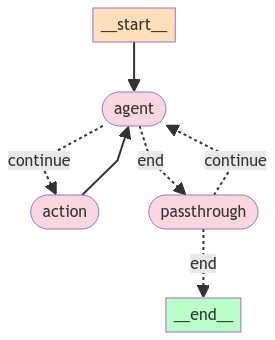

In [42]:
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        agent_with_helpfulness_check.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [43]:
# inputs = {"messages" : [HumanMessage(content="Related to machine learning, what is LoRA? Also, who is Tim Dettmers? Also, what is Attention?")]}
inputs = {"messages" : [HumanMessage(content="Related to astronomy, what is an eclipsing binary star? Also, what are the main types of eclipsing binaries? Also, how does the orbital plane's inclination affect the observation of eclipses?")]}

messages = agent_with_helpfulness_check.invoke(inputs)

print_messages(messages)

Initial Query: Related to astronomy, what is an eclipsing binary star? Also, what are the main types of eclipsing binaries? Also, how does the orbital plane's inclination affect the observation of eclipses?


Agent Response: An eclipsing binary star is a binary star system in which the two stars orbit around a common center of mass in such a way that they periodically eclipse each other as seen from Earth. This results in a periodic decrease in the system's overall brightness when one star passes in front of the other.

There are several main types of eclipsing binaries based on the characteristics of the stars and their orbits:

1. **Detached Eclipsing Binaries**: In this type, the two stars are well-separated and do not interact with each other. Both stars have their own Roche lobes and do not transfer mass between them.

2. **Semi-Detached Eclipsing Binaries**: In this type, one star fills its Roche lobe while the other does not. The star that fills its Roche lobe is called the dono